# Rayleigh Waves Site Effect

In [ ]:
## Distributed python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from math import radians, log

from wmsan.subfunctions_rayleigh_waves import open_bathy, site_effect

__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2024, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "2025.0.0"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@gmail.com"
__status__ = "Production"

## Spatial Extent

In [2]:
# extent
lat_min = -10 # -78 min
lat_max = 50 # 80 max
lon_min = 100 # -180 min
lon_max = 180 # 180 max

extent = [lon_min, lon_max, lat_min, lat_max]

## Bathymetry file 
The bathymetry (or waterlevel) is necessary to compute the site effect for a given phase.

Two bathymetry grids are available for this notebook: 
- (default) "../../data/LOPS_WW3-GLOB-30M_dataref_dpt.nc": a 0.5°x0.5° bathymetry file corresponding to WW3 hindcast resolution.

- (to download) a 1 arcmin resolution ETOPOv2 bathymetry netcdf file.(```refined_bathymetry = True```) 

Both file should be located in the ```ww3-source-maps/data/``` directory.

ETOPOv2 file is also available here: https://www.ngdc.noaa.gov/thredds/catalog/global/ETOPO2022/60s/60s_bed_elev_netcdf/catalog.html?dataset=globalDatasetScan/ETOPO2022/60s/60s_bed_elev_netcdf/ETOPO_2022_v1_60s_N90W180_bed.nc
- [WARNING] use this refined bathymetry on small grids otherwise memory errors might occur (typically 30° lat x 30° lon)

If you wish to use your own bathymetry file:
- latitude in ° 1D array should be named ```zlat```.
- longitude in ° 1D array should be named ```zlon```.
- depth in meters 2D grid should be named ```dpt1```.

(3600, 4800)


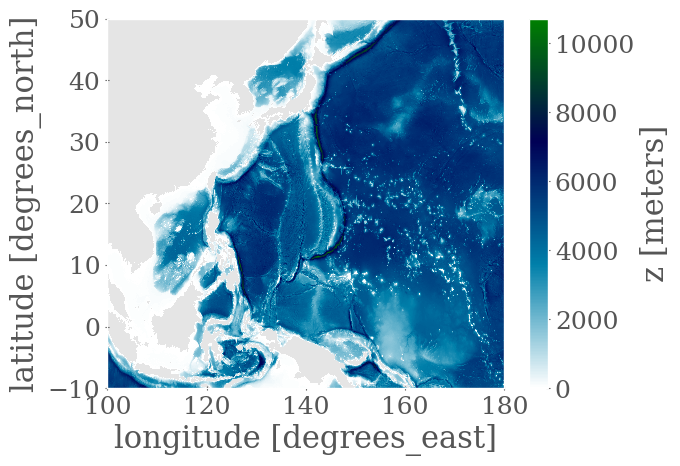

In [3]:
# bathymetry default
file_bathy = "../../data/LOPS_WW3-GLOB-30M_dataref_dpt.nc"  #0.5x0.5 degree grid bathymetry
dpt1, zlon, zlat = open_bathy(file_bathy, refined_bathymetry=True, extent=extent)  # load bathymetry, refined_bathymetry = True
                                                                                   # with ETOPOv2 1 arcmin resolution
print(dpt1.shape)
if dpt1 is None:
    print("Use default bathymetry or download refined.")
else:
    # Plot
    dpt1.plot(cmap='ocean_r')
    plt.show()

## Amplification Coefficients 
We compute the amplitude response functions for the normal modes, from Longuet-Higgins (1950). $ C(f_s, h) = \sum_{i=1}^{4} c_i(f_s,h)^2 $.

Where:
- $h$ is the water column depth in m.
- $f_s$ the seismic frequency in Hz.

For details on the computation see references:
- [Longuet-Higgins, M. S. (1950). A theory of the origin of microseisms. Philosophical Transactions of the Royal Society of London. Series A, Mathematical and Physical Sciences, 243(857), 1-35.](https://royalsocietypublishing.org/doi/10.1098/rsta.1950.0012)

- [Gimbert, F., & Tsai, V. C. (2015). Predicting short-period, wind-wave-generated seismic noise in coastal regions. Earth and Planetary Science Letters, 426, 280-292.](https://www.sciencedirect.com/science/article/abs/pii/S0012821X15003738)

In [4]:
# Amplification map
f = np.array([0.08203799, 0.0902418, 0.09926598, 0.10919258, 0.12011184, 0.13212304,
                0.14533535, 0.15986888, 0.17585577, 0.19344135, 0.21278548, 0.23406404,
                0.25747046, 0.28321752, 0.3115393,  0.34269324, 0.37696257, 0.41465884,
                0.45612472, 0.50173724, 0.55191094, 0.60710204])
vs_crust = 2800 ## m/s, crustal shear wave velocity

print("THIS SHOULD TAKE 3 MINUTES TO RUN")
path = '../../data/longuet_higgins.txt'
if os.path.isfile('../../data/c_cufstom.nc'):
    print("File already exists. Skipping")
    amplif = xr.open_dataarray('../../data/c_custom.nc')
else:
    amplif = site_effect(dpt1, f, zlat, zlon, vs_crust, path)

THIS SHOULD TAKE 3 MINUTES TO RUN


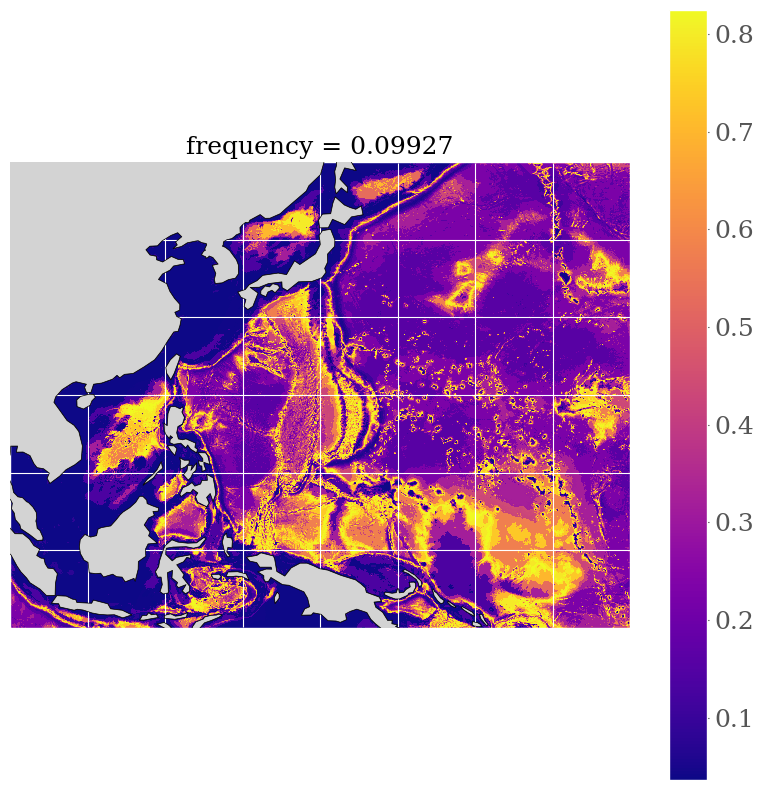

In [5]:
# Plot 
amplif_plot = amplif.sel(frequency= 0.1, method='nearest')
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("Amplification coefficient")
ax.coastlines()
ax.gridlines()
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k', facecolor='lightgrey')
amplif_plot.plot(cmap='plasma', transform=ccrs.PlateCarree(), ax=ax)
plt.show()

## Save to netcdf

In [6]:
if not os.path.isfile('../../data/c_custom.nc'):
    # Create netCDF 
    amplif.to_netcdf('../../data/c_custom.nc')